In [5]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [6]:
import numpy as np
import pandas as pd

In [7]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [8]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [10]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [11]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [12]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [13]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [14]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

2017-08-23
2016-08-22


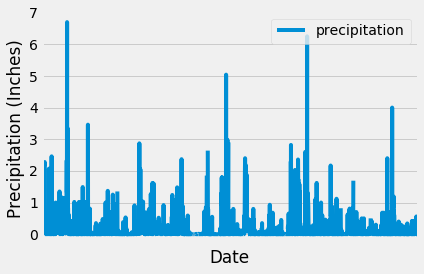

In [96]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
last_12months = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

# Last data point on DB
last_12months = last_12months[0]
print(last_12months)

# Calculate the date 1 year ago from the last data point in the database
oneyear_ago = dt.date(2017,8,23) - dt.timedelta(days=366)
print(oneyear_ago)

# Perform a query to retrieve the data and precipitation scores
date_prcp = session.query(Measurement.date, Measurement.prcp).filter(Measurement.date >= oneyear_ago).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
climate_df = pd.DataFrame (date_prcp,columns=['date', 'precipitation'])

# Sort the dataframe by date

#1 Set index to date
climate_df.set_index('date', inplace=True)

#Sorting
climate_df = climate_df.sort_values(by='date',ascending=True)


# Use Pandas Plotting with Matplotlib to plot the data
climate_df.plot()
plt.legend(loc= "upper right")
plt.xlabel('Date')
plt.ylabel('Precipitation (Inches)')
plt.xticks ([],[])
plt.savefig("Precipitation.png")
plt.show()




![precipitation](Images/precipitation.png)

In [85]:
# Use Pandas to calcualte the summary statistics for the precipitation data
climate_df.describe()



,precipitation
count,2026.000000
mean,0.179437
std,0.463989
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


![describe](Images/describe.png)

In [89]:
# Design a query to show how many stations are available in this dataset?
available_stations = session.query(Measurement.station).distinct().count()
print(f"There are {available_stations} stations available.")


There are 9 stations available.


In [97]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
most_active_stations= session.query(Measurement.station, 
func.count(Measurement.station)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).all()
most_active_stations



[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [103]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
top_station = most_active_stations[0][0]

temp_stats_top_station = session.query(func.min(Measurement.tobs),
    func.max(Measurement.tobs),func.avg(Measurement.tobs)).filter(Measurement.station == top_station)

temp_stats_top_station_list=list(temp_stats_top_station)
print(temp_stats_top_station_list)

[(54.0, 85.0, 71.66378066378067)]


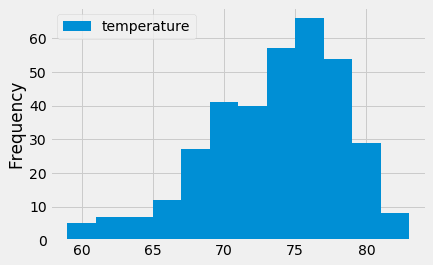

In [111]:
# Choose the station with the highest number of temperature observations.

top_temp_station = session.query(Measurement.station,
    func.count(Measurement.tobs)).group_by(Measurement.station).order_by(func.count(Measurement.station).desc()).first()
top_temp_station= top_temp_station[0]

# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

temp_obs = session.query( Measurement.tobs).filter(Measurement.date >= oneyear_ago).filter(Measurement.station == top_temp_station).all()
temp_obs = pd.DataFrame(temp_obs, columns=['temperature'])


# Graph - histogram
temp_obs.plot.hist(bins=12)
plt.savefig("Temperature_most_active_station.png")
plt.show()

![precipitation](Images/station-histogram.png)

In [113]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [115]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
my_trip = calc_temps ('2017-06-15','2017-06-25')
print (my_trip)

[(71.0, 76.79411764705883, 82.0)]


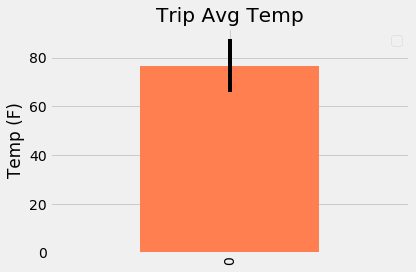

In [126]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

my_trip_temp_df = pd.DataFrame(my_trip, columns=['tmin', 'tavg', 'tmax'])
my_trip_temp_df.plot.bar(y='tavg', yerr=(my_trip_temp_df['tmax'] - my_trip_temp_df['tmin']), title='Trip Avg Temp', color = 'coral')

plt.ylabel("Temp (F)")
plt.tight_layout()
plt.legend([])
plt.savefig("MyTripAvgTemp.png")
plt.show()
